# Attempt to DataClean - Claude

In [2]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt


#for the "heavy" work:
from dateutil.parser import parse
import matplotlib as mpl
from matplotlib.pylab import rcParams

import seaborn as sns
#import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf

#from statsmodels.tsa.arima_model import ARIMA

In [3]:
df_aegeri = pd.read_csv("./data/df_aegeri_skin.csv")
df_aegeri.head()

,x,y,y1,datetime,air_temp,wind_speed,air_pressure,relative_humidity,solar_irradiance,meteo_timestamp
0,1.668164e+09,13.30,NaN,2022-11-11 12:00:28.166,NaN,NaN,NaN,NaN,NaN,1.668164e+09
1,1.668165e+09,12.85,13.0560,2022-11-11 12:10:12.659,11.219889,0.335625,947.745833,76.005556,370.370833,1.668165e+09
2,1.668166e+09,13.66,13.0500,2022-11-11 12:20:12.554,11.311667,0.621000,947.471528,76.269444,352.027778,1.668166e+09
3,1.668166e+09,13.40,13.1005,2022-11-11 12:30:12.576,11.248043,0.623468,947.491798,76.381186,356.725934,1.668166e+09
4,1.668167e+09,13.43,13.0826,2022-11-11 12:40:12.537,11.646126,0.486770,947.544732,74.100976,357.692413,1.668167e+09


In [4]:
df_aegeri["datetime"]=pd.to_datetime(df_aegeri["datetime"])

## 1.1 plot the data

In [5]:
df_aegeri.index=df_aegeri["datetime"]

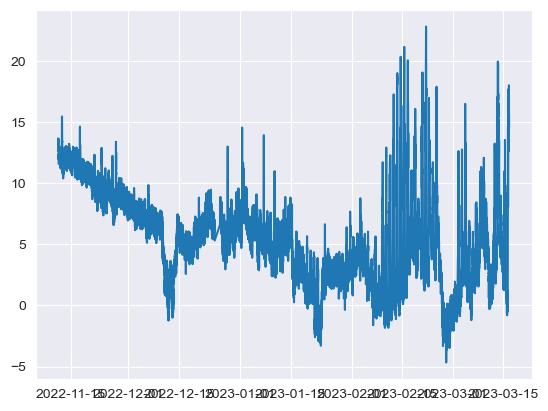

In [6]:
plt.plot(df_aegeri["y"])

### Good, the csv loaded correctly: Now to reduplicate all the following stept, I think it is the best if we make a Class in order to throw all the generated csv at. It is important that the structure of the csv is not changing.

In [61]:
class Data:
    def __init__(self,path,name):
        self.path=path
        self.name=name
        self.dataframe=pd.read_csv(path)
        self.columns=self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"]=pd.to_datetime(self.dataframe["datetime"])
        self.dataframe.index=self.dataframe["datetime"]
        self.dataframe=self.dataframe.drop(columns=["datetime"])


    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self,column,window,statistics,plot="no",save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()


        if print != "no":
            plt.style.context
            plt.figure(figsize=(20,10))
            actual=plt.plot(self.dataframe[column], color='red', label='Actual',alpha=0.7)
            mean_rm=plt.plot(mean_rm, color='green', label=f'Rolling Mean (window: {window})',alpha=0.7)
            std_rm=plt.plot(std_rm, color='black', label=f'Rolling Std (window: {window})',alpha=0.7)
            plt.legend(loc='best')
            plt.title('Rolling Mean & Standard Deviation')
            if save_plot =="yes":
                plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
            elif save_plot != "no":
                plt.savefig(f"./data/output_png/{save_plot}.png")

            plt.show(block=False)

    def check_stationarity(self,column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print("->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        self.dataframe[column].hist()
        print("Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest=adfuller(X, autolag='AIC')
        dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we fail to reject the null hypothesis, that the data is stationary.")
        else:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we reject the null hypothesis, that the data is stationary.")
        print(dfoutput)

    def AutoRegressiveModel(self,column): #source/idea: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
        print("The Auto-Regressive (AR) model assumes that the current value (y_t) is dependent on previous values (y_(t-1), y_(t-2), …). Because of this assumption, we can build a linear regression model.\nTo figure out the order of an AR model, you need to look at the PACF:\n------------------------------------------------------------------------------")

        lag_pacf=pacf(self.dataframe[column], nlags=10, method='ols')

        plt.subplot()
        plt.plot(lag_pacf)
        plt.axhline(y=0,linestyle='--',color='green')
        plt.axhline(y=-1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.axhline(y=1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.title('Partial Autocorrelation Function')

    def AutocorrelationModel(self,column):
        plot_acf(self.dataframe[column],lags=10)


    def activate_testingmodus(self):
        self.dataframe=self.dataframe[1:100]

    def detect_outlier(self,column):
        print("DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) ")
        if column=="all":
            sns.boxplot(data=self.dataframe)
            plt.title("Boxplot of the whole dataset")
            plt.show()
        else:
            sns.boxplot(data=self.dataframe[column])
            plt.title(f"Boxplot of the column {column}")
            plt.xlabel(f"{column}")
            plt.show()

            q1=self.dataframe[column].quantile(0.25)
            q3=self.dataframe[column].quantile(0.75)
            IQR=q3-q1
            outliers=self.dataframe[column][((self.dataframe[column]<(q1-1.5*IQR)) | (self.dataframe[column]>(q3+1.5*IQR)))]
            plt.plot(self.dataframe[column],label=f"{column}",alpha=0.2)
            plt.plot(outliers,marker=".",linestyle="",label="outliers")
            plt.legend(loc='best')
            plt.title(f"Outliers in {column}")
            plt.show()


########################################################################################################################
            #HIER WEITERMACHEN

            input_=input(f"Do you want the outliers of {column} returned as a DataFrame [Option 1], or do you want the Outlier-cleaned Dataframe [Option 2]. For Option 1, type '1', for Option 2, type '2'.")
            if input_ == "1":
                return outliers
            elif input_ == "2":
                cleaned=self.dataframe[column]
                cond = self.dataframe[column].isin(outliers)
                cleaned.drop(cleaned[cond].index, inplace = True)
                print("--------------------------------------------------------------")
                print(f"% of outliers:{round(((len(outliers)/len(cleaned))*100),2)}% of {len(self.dataframe[column])} observations")
                print("--------------------------------------------------------------")
                plt.plot(cleaned)
                plt.title(f"cleaned Dataframe from {column}")
                plt.show()
                return cleaned

In [62]:
path="./data/df_aegeri_skin.csv"
name="LakeAegeri"

In [63]:
LakeAegeri=Data(path,name)
LakeAegeri.dataframe.describe()
#LakeAegeri.activate_testingmodus() #for testing of the code

,x,y,y1,air_temp,wind_speed,air_pressure,relative_humidity,solar_irradiance,meteo_timestamp
count,1.767000e+04,17660.000000,16931.000000,17669.000000,17669.000000,17669.000000,17669.000000,17669.000000,1.767000e+04
mean,1.673590e+09,5.498787,6.549381,3.305329,2.211551,932.562797,85.306796,57.216367,1.673590e+09
std,3.133246e+06,3.723349,2.402112,4.072081,1.641417,9.748978,12.034371,117.964297,3.133245e+06
min,1.668164e+09,-4.670000,4.034900,-6.793139,0.111960,899.729028,29.851389,0.000000,1.668164e+09
25%,1.670841e+09,2.780000,4.635950,0.368208,1.043225,925.834622,78.362076,0.000000,1.670841e+09
50%,1.673629e+09,5.350000,5.760500,3.375333,1.701356,932.927500,87.700000,0.391667,1.673629e+09
75%,1.676301e+09,7.780000,7.627650,6.144889,2.925750,940.226389,94.661864,57.113889,1.676301e+09
max,1.678978e+09,22.810000,13.205700,16.621930,13.868181,951.255278,100.000000,776.469444,1.678978e+09


In [64]:
#LakeAegeri.AutoRegressiveModel(column="y")

DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) 


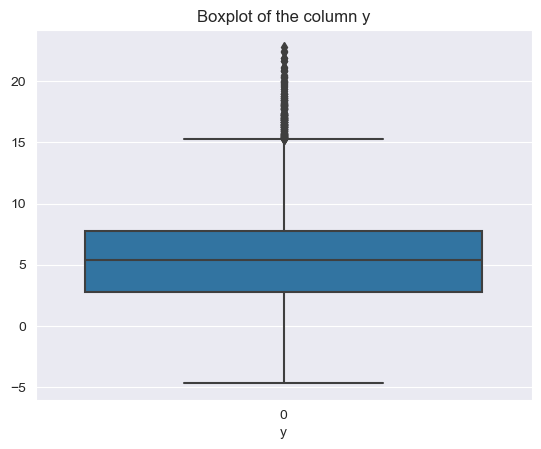

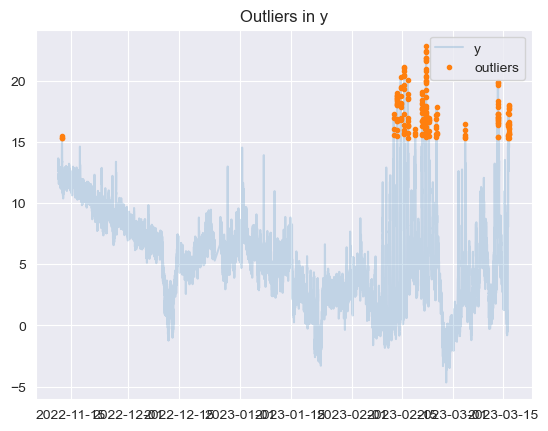

--------------------------------------------------------------
% of outliers:0.99% of 17670 observations
--------------------------------------------------------------


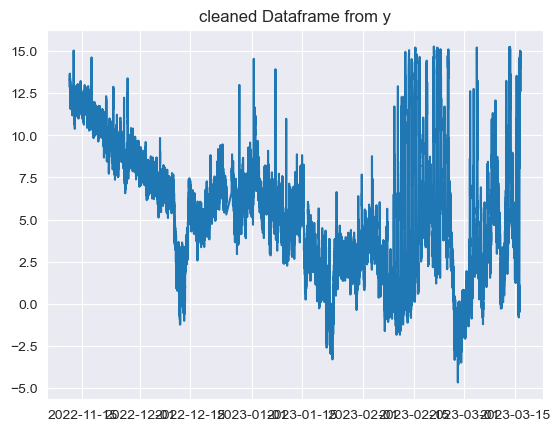

datetime
2022-11-11 12:00:28.166    13.30
2022-11-11 12:10:12.659    12.85
2022-11-11 12:20:12.554    13.66
2022-11-11 12:30:12.576    13.40
2022-11-11 12:40:12.537    13.43
                           ...  
2023-03-16 13:10:12.566    14.98
2023-03-16 13:50:12.527    12.61
2023-03-16 14:00:12.593    14.50
2023-03-16 14:10:12.609    14.96
2023-03-16 15:40:12.602    14.53
Name: y, Length: 17497, dtype: float64

In [65]:
LakeAegeri.detect_outlier("y")

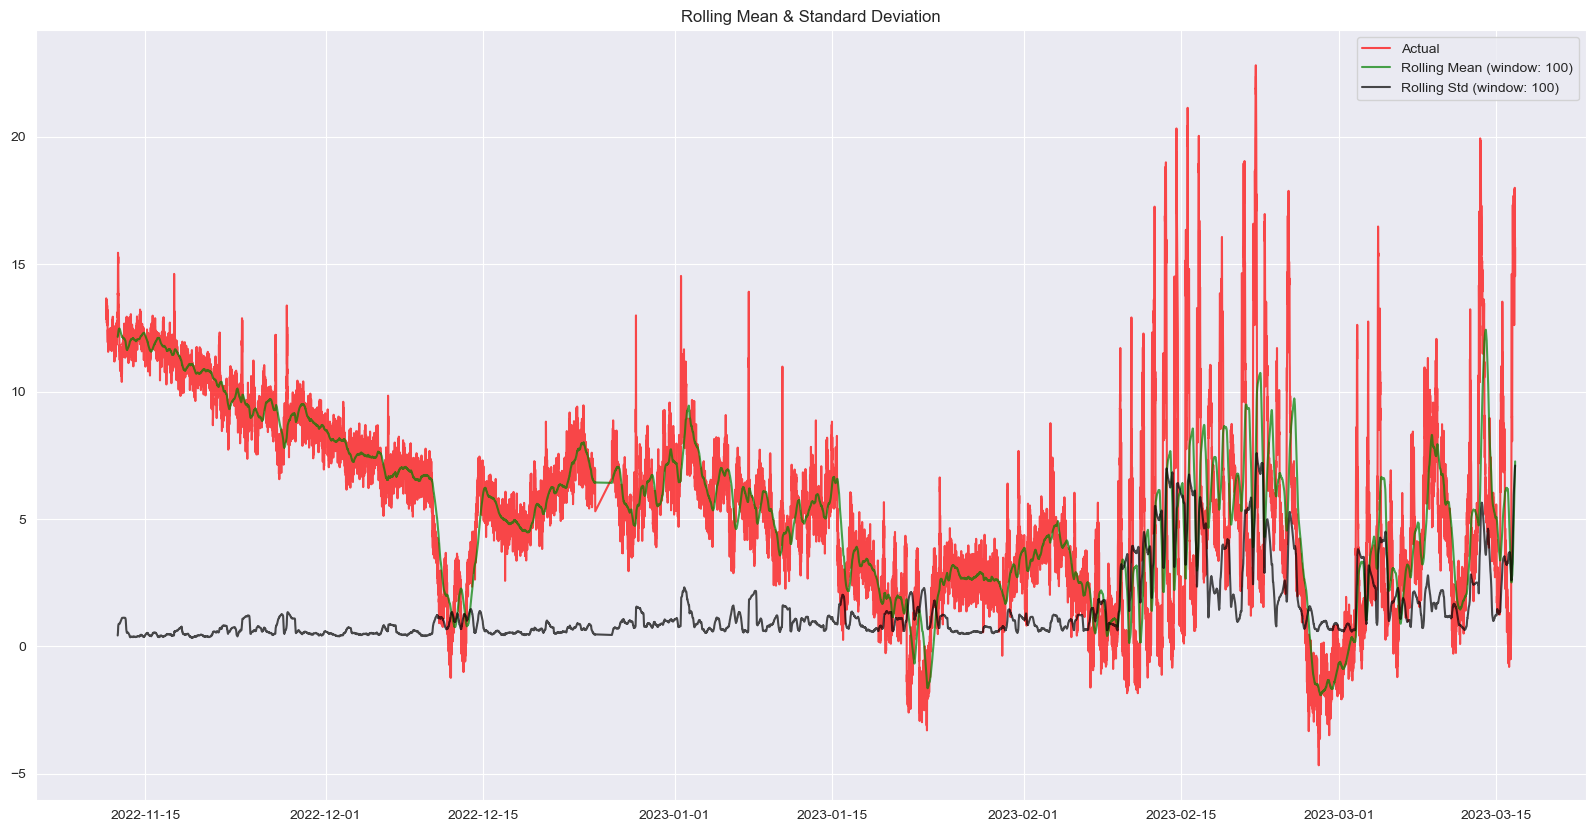

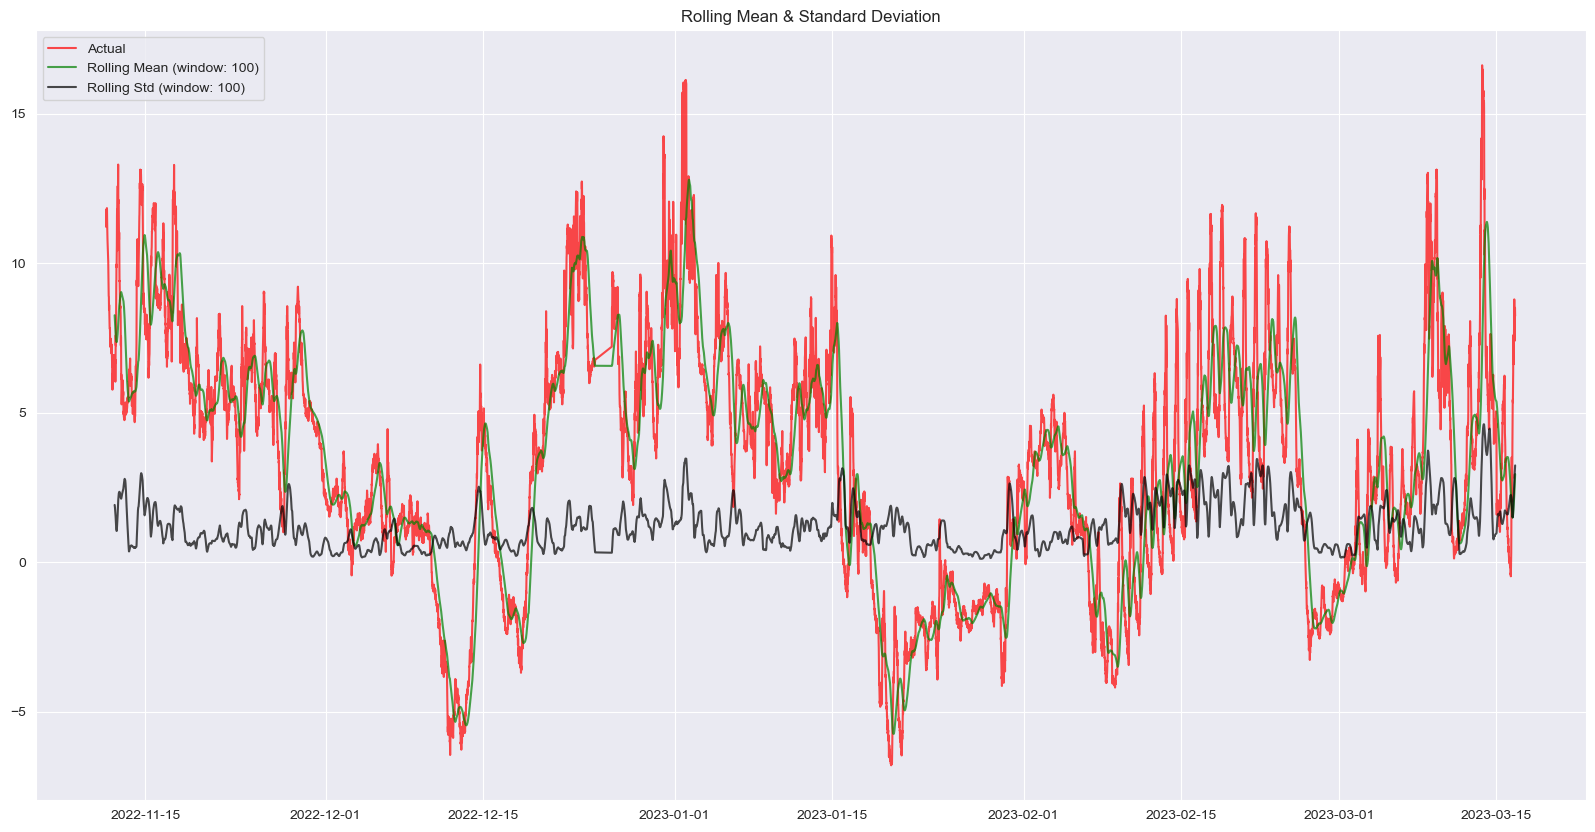

In [49]:
LakeAegeri.calc_rolling_statistics(window=100,column="y",statistics="mean",plot="no",save_plot="rolling_mean")
LakeAegeri.calc_rolling_statistics(window=100,column="air_temp",statistics="mean",plot="no")

In [50]:
#LakeAegeri.check_stationarity(column="y")